# **I LOVE PANDAS**

![PANDA](https://media4.giphy.com/media/ue2Mb3oHDmMmc/200w.gif?cid=6c09b952l8sef3qps8u3v1kc880w0kji5luz2we7uaf62y7r&ep=v1_gifs_search&rid=200w.gif&ct=g)    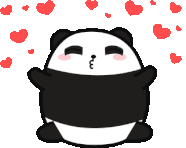       ![DELETE](https://princesselifestyle.files.wordpress.com/2014/11/tumblr_n2t9ubd5td1s36kfoo1_500.gif)





## Intro + EDA

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# Load data
fraudie = pd.read_csv("input_data2/financial_transaction_data.csv")

# EDA
print(fraudie.shape)
print(" ")
print(fraudie.head())
print(" ")
print(fraudie.info())
print(" ")
print(fraudie.describe())
print(" ")

# Missing values (nada bubba)
missing_values = fraudie.isnull().sum()
print(missing_values)
print(" ")




(6362620, 11)
 
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data co

## Outliers

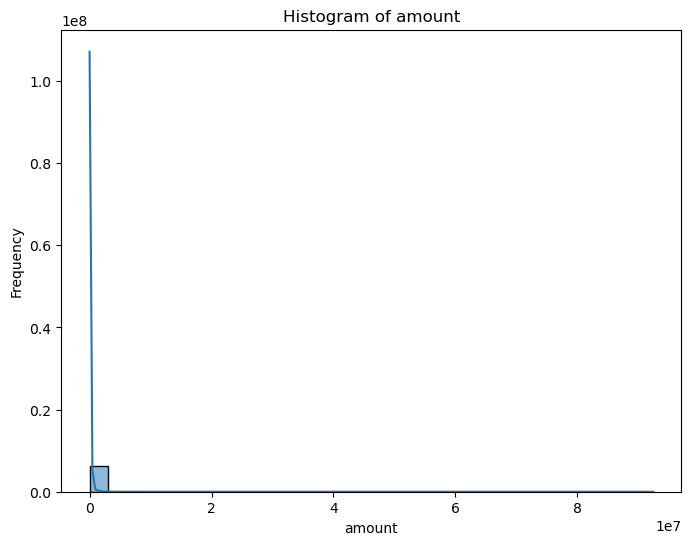

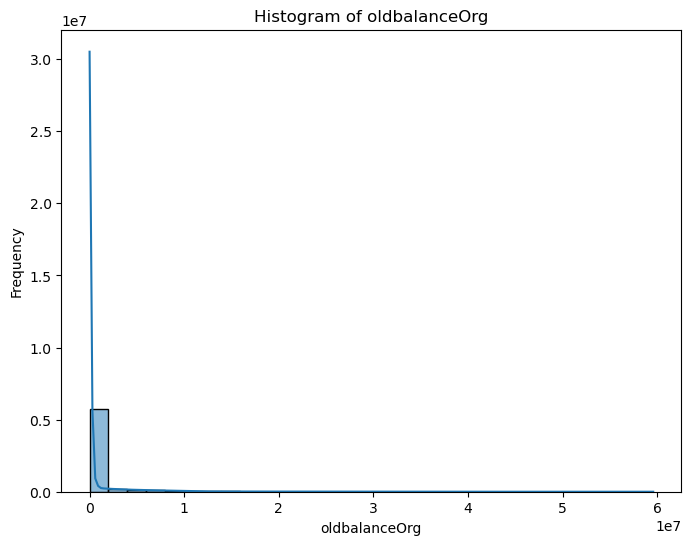

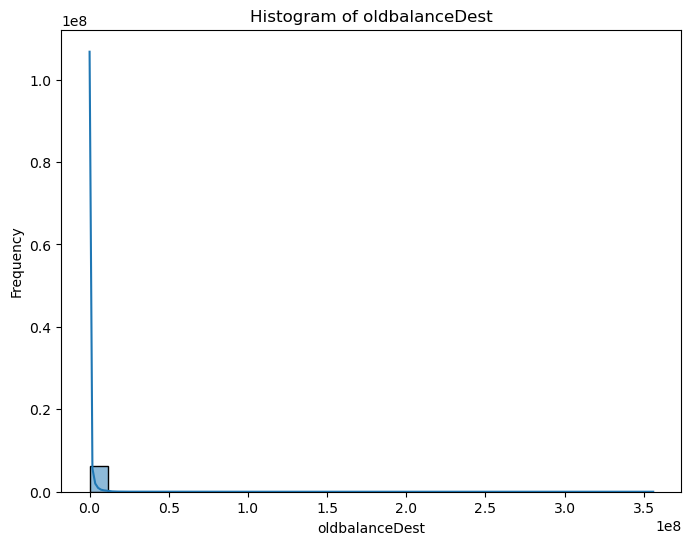

In [2]:
# Select numerical features for visualization
numerical_features = ['amount', 'oldbalanceOrg', 'oldbalanceDest']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=fraudie, x=feature, bins=30, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

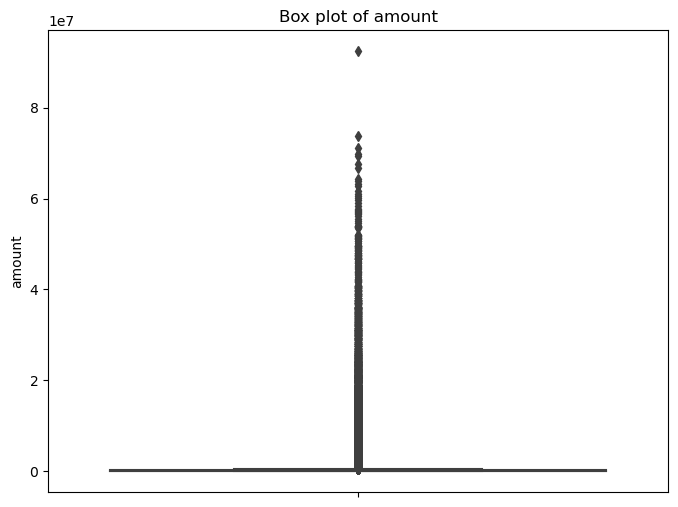

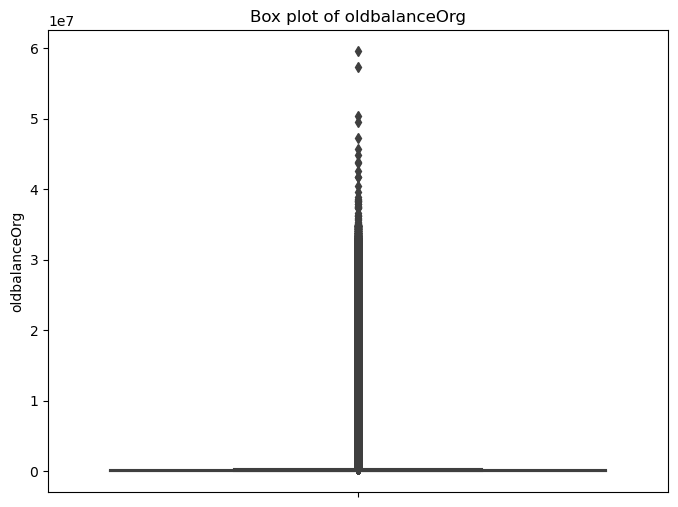

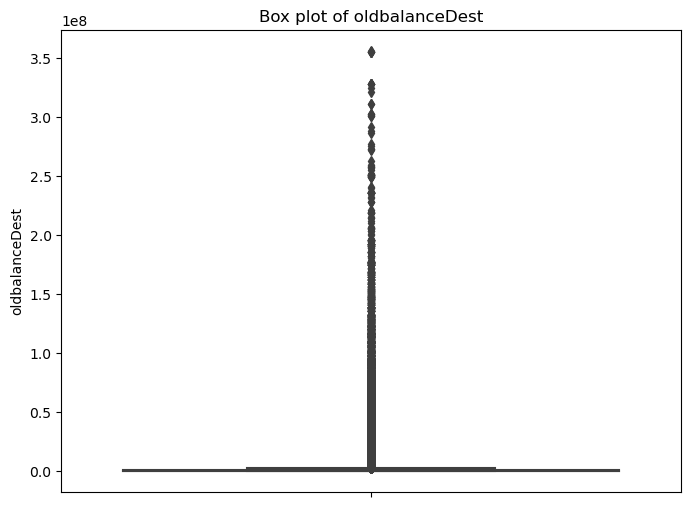

In [3]:
# Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=fraudie, y=feature)
    plt.title(f'Box plot of {feature}')
    plt.ylabel(feature)
    plt.show()


## Relationship Between Variables + isFraud

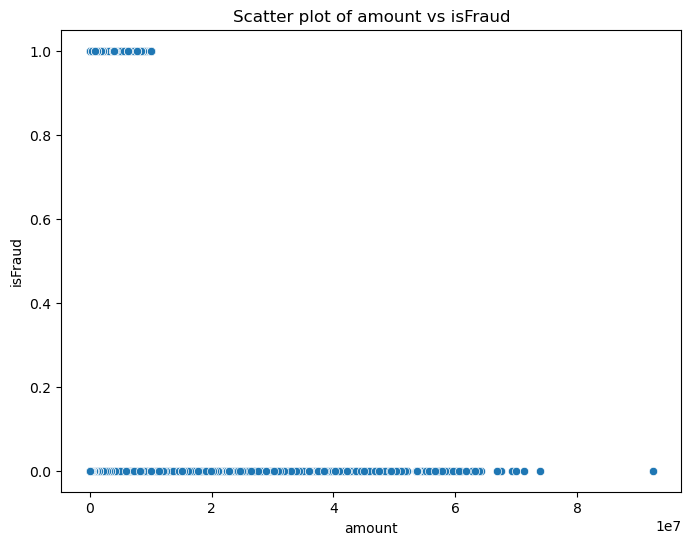

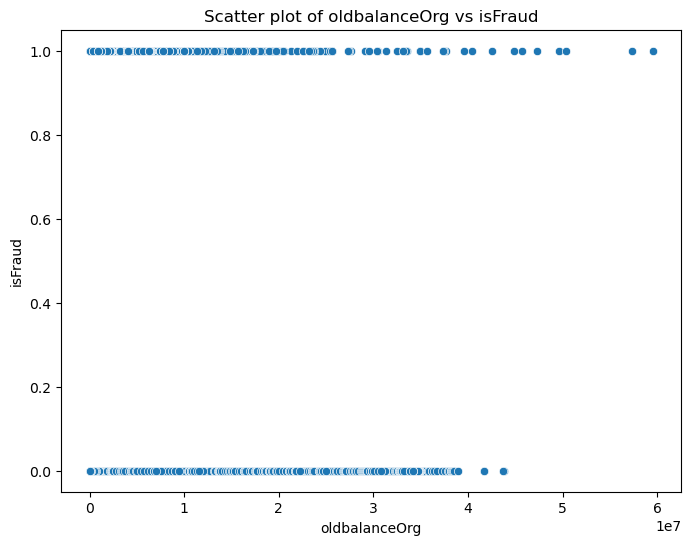

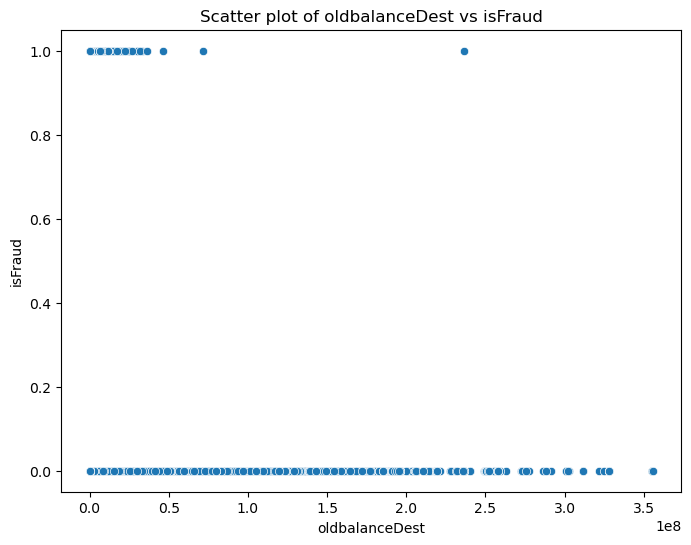

In [4]:
# Plot scatter plots for numerical features against 'isFraud'
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=fraudie, x=feature, y='isFraud')
    plt.title(f'Scatter plot of {feature} vs isFraud')
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.show()


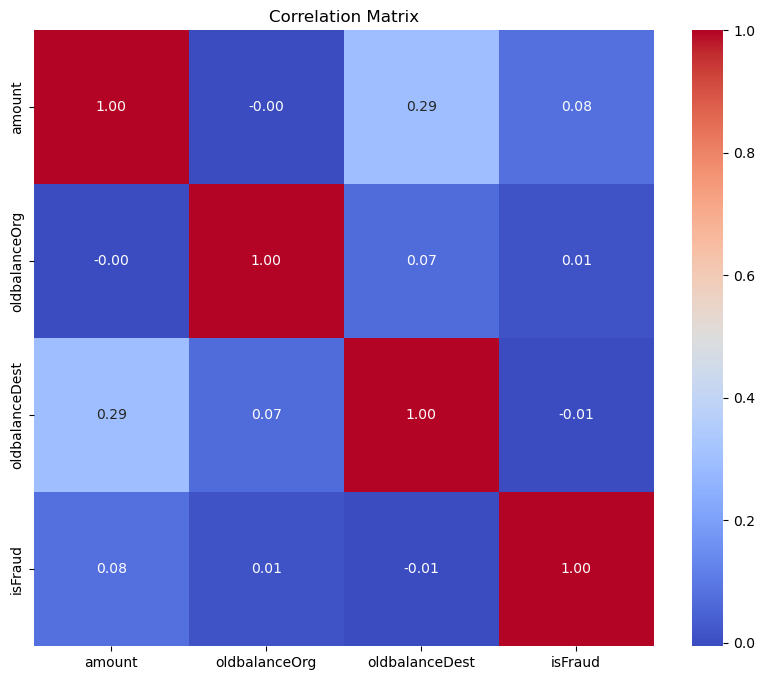

In [14]:
# Calculate correlation matrix
correlation_matrix = fraudie[numerical_features + ['isFraud']].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('pics/plot1.png')
plt.show()

In [8]:
# Set random seed for reproducibility
rng = np.random.RandomState(0)
sample_size = 100000
# Proportion of fraudulent transactions in the sample
fraud_proportion = 0.2  # Adjust as needed

# Sample a subset of the data including both nonfraud and fraud transactions
fraudie_fraud = fraudie[fraudie['isFraud'] == 1]
fraudie_non_fraud = fraudie[fraudie['isFraud'] == 0].sample(int(sample_size * (1 - fraud_proportion)), random_state=rng)
fraudie_sampled = pd.concat([fraudie_fraud, fraudie_non_fraud], axis=0)

# Shuffle dataset
fraudie_sampled = fraudie_sampled.sample(frac=1, random_state=rng)

os.makedirs('randooutput', exist_ok=True)
fraudie_sampled.to_csv('randooutput/fraudie_sampled.csv', index=False)

# Split off X and y from the sampled dataset
y_sampled = fraudie_sampled['isFraud']
X_sampled = fraudie_sampled.drop('isFraud', axis=1)

# Split the sampled data into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=rng)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['type', 'nameOrig', 'nameDest']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X_sampled.select_dtypes(include=['int64', 'float64']).columns),
    ('cat', categorical_transformer, categorical_features)
])

# Model selection pipeline with Random Forest
model = RandomForestClassifier(random_state=0)
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

# Hyperparametrs
param_dist = {
    'model__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'model__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'model__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
}

random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train_sampled, y_train_sampled)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': None}
Best score: 0.9832081645113453


In [9]:
# Predict on test set
y_pred = random_search.predict(X_test_sampled)

# Compute evaluation metrics
accuracy = accuracy_score(y_test_sampled, y_pred)
precision = precision_score(y_test_sampled, y_pred)
recall = recall_score(y_test_sampled, y_pred)
f1 = f1_score(y_test_sampled, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9850
Precision: 0.9910
Recall: 0.8501
F1-score: 0.9151


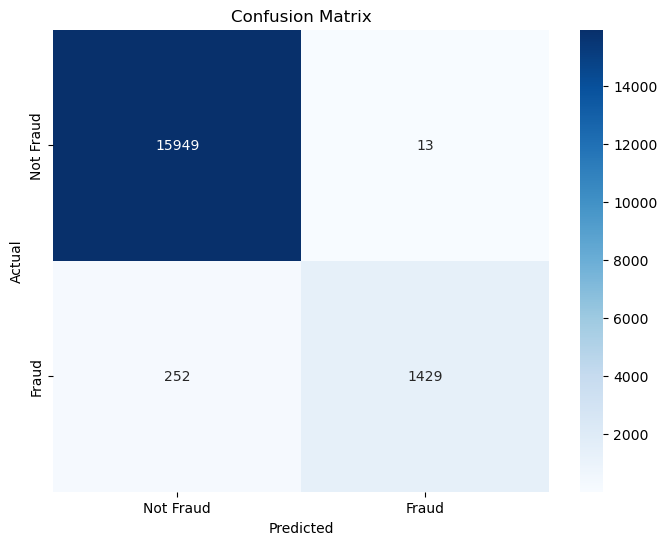

In [15]:
cm = confusion_matrix(y_test_sampled, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('pics/plot2.png')
plt.show()


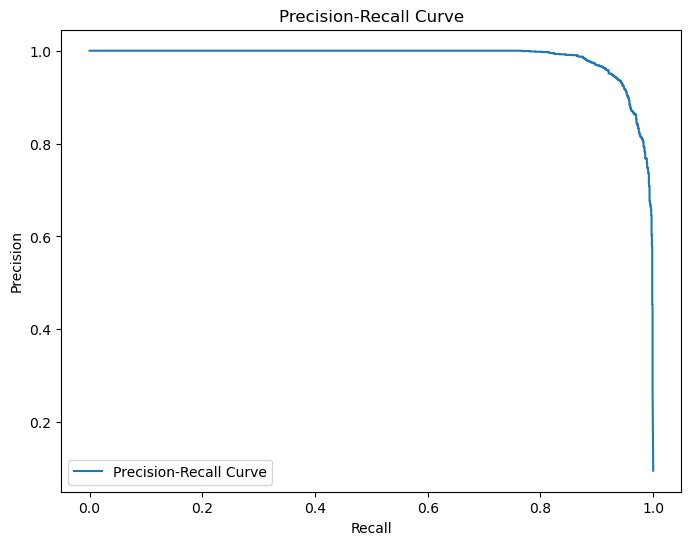

In [16]:

# Get predicted probabilities
y_pred_proba = random_search.best_estimator_.predict_proba(X_test_sampled)

# Keep probabilities for fraud only
y_pred_proba = y_pred_proba[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_sampled, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig('pics/plot3.png')
plt.show()

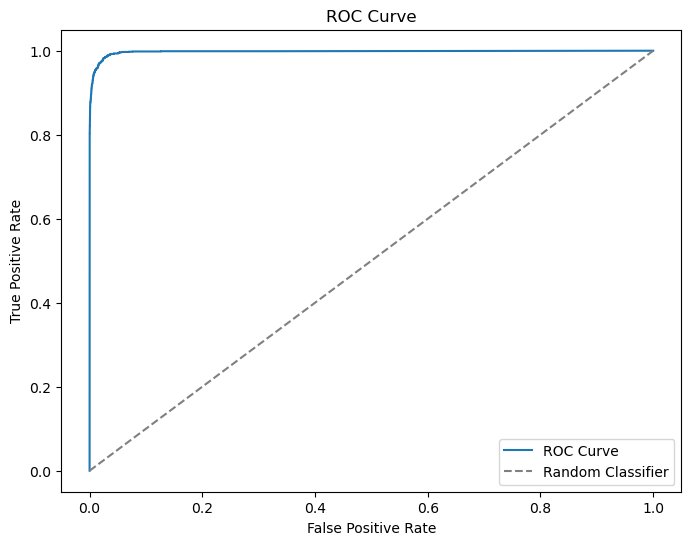

In [17]:
# Gettie predicted probabilities
y_pred_proba = random_search.best_estimator_.predict_proba(X_test_sampled)

# Keep probabilities for fraud only
y_pred_proba = y_pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sampled, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('pics/plot4.png')
plt.show() #testtttt